In [1]:
from typing import *
import torch
from torch import nn
from torchtyping import TensorType, patch_typeguard
from transformer import Transformer
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import numpy as np
from permutation import Permutation

%load_ext autoreload
%autoreload 2

patch_typeguard()

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device used : {device}')

Device used : cuda:0


# Dataset generation definitions

In [3]:
@dataclass
class Dataset:
    train_x: TensorType["batch", "seq_len"]
    train_y: TensorType["batch", "seq_len"]
    test_x: TensorType["batch", "seq_len"]
    test_y: TensorType["batch", "seq_len"]

def split_dataset(data_x, data_y, prop: float = 0.8) -> Dataset:
    """
    Split the given dataset into training and test sets.
    """
    order = torch.randperm(data_x.shape[0])
    train_size = int(prop * data_x.shape[0])

    return Dataset(
        train_x = data_x[order[:train_size]],
        train_y = data_y[order[:train_size]],
        test_x = data_x[order[train_size:]],
        test_y = data_y[order[train_size:]],
    )

class BinaryOperator:
    def __init__(self, op):
        self.op     = np.vectorize(op)
        
    def apply(self, x, y):
        return self.op(x, y)
    
np_pow_mod = np.frompyfunc(pow, 3, 1)

## Operations in Zp (p=97)
p = 11
addition_mod_p           = BinaryOperator(lambda x, y: (x + y) % p)
subtraction_mod_p        = BinaryOperator(lambda x, y: (x - y) % p)
division_mod_p           = BinaryOperator(lambda x, y: (x * np_pow_mod(y, -1, p)) % p)
div_or_sub_mod_p         = BinaryOperator(lambda x, y: (x * np_pow_mod(y, -1, p)) %p if (y % 2 == 1) else (x-y) %p)
sum_of_squares_mod_p     = BinaryOperator(lambda x, y: (np_pow_mod(x, 2, p) + np_pow_mod(y, 2, p)) %p)
sum_of_mixed_terms_mod_p = BinaryOperator(lambda x, y: (np_pow_mod(x, 2, p) + x*y + np_pow_mod(y, 2, p)) %p)
fancy_sum_mod_p_1        = BinaryOperator(lambda x, y: (np_pow_mod(x, 2, p) + x*y + np_pow_mod(y, 2, p) + x) %p)
fancy_sum_mod_p_2        = BinaryOperator(lambda x, y: (np_pow_mod(x, 3, p) + x*y) %p)
fancy_sum_mod_p_3        = BinaryOperator(lambda x, y: (np_pow_mod(x, 3, p) + x*np_pow_mod(y, 2, p) + y) %p)

def create_dataset(op: BinaryOperator, x, y, p):
    xv, yv = np.meshgrid(x, y)
    
    numeric_results = op.apply(xv, yv)
        
    ds = np.dstack((xv, yv))
    ds_size = ds.size
    
    inputs  = torch.tensor(np.dstack((xv, yv)).reshape((ds_size//2, 2))).long().to(device)
    outputs = torch.tensor(numeric_results.reshape((ds_size//2))).long().to(device)
    
    return inputs, outputs

# Training

In [4]:
@dataclass
class TrainingLog:
    train_losses: list[float] = field(default_factory=list)
    test_losses: list[float] = field(default_factory=list)
    train_acc: list[float] = field(default_factory=list)
    test_acc: list[float] = field(default_factory=list)
    epochs: list[float] = field(default_factory=list)

    def plot(self):
        # Two plots, one for loss, one for accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.set_xscale("log")
        ax1.plot(self.epochs, self.train_losses, label="training")
        ax1.plot(self.epochs, self.test_losses, label="test")
        ax1.title.set_text("Loss")
        ax1.legend()
        
        ax2.set_xscale("log")
        ax2.plot(self.epochs, self.train_acc, label="training")
        ax2.plot(self.epochs, self.test_acc, label="test")
        # line at acc = 1
        ax2.axhline(1, color="black", linestyle="--")
        ax2.title.set_text("Accuracy")
        ax2.legend()
        
def train(epochs, model, optimizer, data: Dataset, logs: TrainingLog):
    loss_fn = nn.CrossEntropyLoss()

    if logs.epochs:
        start_epoch = logs.epochs[-1] + 1
    else:
        start_epoch = 0

    for epoch in range(start_epoch, start_epoch + epochs):
        pred = model(data.train_x)
        loss = loss_fn(pred, data.train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 10 == 0:
            logs.epochs.append(epoch)
            logs.train_losses.append(loss.item())
            logs.train_acc.append((pred.argmax(dim=1) == data.train_y).float().mean().item())
            test_pred = model(data.test_x)
            logs.test_losses.append(loss_fn(test_pred, data.test_y).item())
            logs.test_acc.append((test_pred.argmax(dim=1) == data.test_y).float().mean().item())

# Experiments

In [5]:
OPERATIONS_MOD_97 = [addition_mod_p, subtraction_mod_p, division_mod_p, div_or_sub_mod_p, sum_of_squares_mod_p, sum_of_mixed_terms_mod_p, fancy_sum_mod_p_1, fancy_sum_mod_p_2, fancy_sum_mod_p_3]
OPTIMIZATION_BUDGET = 1000

In [6]:
def learning_curve_experiment(op: BinaryOperator, op_title:str, startY=0):
    group_size = 11
    dmodel = 128
    avg_accs = []
    splits = np.arange(0.1, 1, 0.2)

    for split in splits:
        accs = []

        for i in range(3):
            print(f"[{op_title}] Split {split}, run {i+1}/3r")
            torch.manual_seed(i)
            data_x, data_y = create_dataset(op, np.arange(group_size), np.arange(startY, group_size), p=group_size)
            data = split_dataset(data_x, data_y, split)

            model = Transformer(
                voc_size=group_size,
                embedding_size=dmodel,
                depth=2,
                heads=4,
                mlp_dims=[4 * dmodel],
            ).to(device)

            epochs = OPTIMIZATION_BUDGET

            optimizer=torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=1)

            logs = TrainingLog()
            train(epochs, model, optimizer, data, logs)
            accs.append(max(logs.test_acc))
        avg_accs.append(sum(accs) / 3)
        
    return splits, avg_accs

In [7]:
experiment = [learning_curve_experiment(OPERATIONS_MOD_97[0], "x + y mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[1], "x - y mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[2], "x / y mod 11", startY=1),
learning_curve_experiment(OPERATIONS_MOD_97[3], "x / y mod 11 if y odd else x - y mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[4], "x^2 + y^2 mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[5], "x^2 + xy + y^2 mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[6], "x^2 + xy + y^2 + x mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[7], "x^3 + xy mod 11"),
learning_curve_experiment(OPERATIONS_MOD_97[8], "x^3 + x^2 + y mod 11")]

[x + y mod 11] Split 0.1, run 1/3r
[x + y mod 11] Split 0.1, run 2/3r
[x + y mod 11] Split 0.1, run 3/3r
[x + y mod 11] Split 0.30000000000000004, run 1/3r
[x + y mod 11] Split 0.30000000000000004, run 2/3r
[x + y mod 11] Split 0.30000000000000004, run 3/3r
[x + y mod 11] Split 0.5000000000000001, run 1/3r
[x + y mod 11] Split 0.5000000000000001, run 2/3r
[x + y mod 11] Split 0.5000000000000001, run 3/3r
[x + y mod 11] Split 0.7000000000000001, run 1/3r
[x + y mod 11] Split 0.7000000000000001, run 2/3r
[x + y mod 11] Split 0.7000000000000001, run 3/3r
[x + y mod 11] Split 0.9000000000000001, run 1/3r
[x + y mod 11] Split 0.9000000000000001, run 2/3r
[x + y mod 11] Split 0.9000000000000001, run 3/3r
[x - y mod 11] Split 0.1, run 1/3r
[x - y mod 11] Split 0.1, run 2/3r
[x - y mod 11] Split 0.1, run 3/3r
[x - y mod 11] Split 0.30000000000000004, run 1/3r
[x - y mod 11] Split 0.30000000000000004, run 2/3r
[x - y mod 11] Split 0.30000000000000004, run 3/3r
[x - y mod 11] Split 0.50000000000

In [8]:
titles = ["x+y", "x-y", "x/y", "x/y or x-y", "x^2 + y^2", "x^2 +xy+ y^2", "x^2 + xy + y^2 + x", "x^3 + xy", "x^3 + x^2 + y"]  

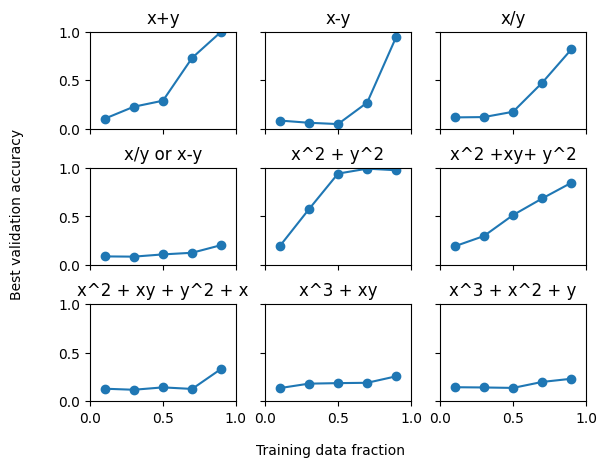

In [9]:
fig, axes = plt.subplots(3, 3, sharex='col', sharey='row')

ctr = 0
for ax in axes.flatten():
    splits, accuracies = experiment[ctr]
    accuracies = np.nan_to_num(accuracies)
    ax.plot(splits, accuracies, "-o")
    ax.set(title=titles[ctr], xlim=[0,1], ylim=[0,1])
    ctr = ctr + 1

fig.text(0.5,0,'Training data fraction', ha="center")
fig.text(0,0.5,'Best validation accuracy', va="center", rotation="vertical")

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()